# 7: Loss functions, L0 and L2 Regularization

## Imports

In [2]:
import os
import sys

sys.path.append("code/.")
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import numpy.linalg as npla
import numpy.random as npr
import pandas as pd
from IPython.display import display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn import datasets
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

### Outline

- Explain the intuition behind 1/0, exponential, hinge and logistic loss. 
- Explain the difference between sigmoid and logistic loss. 
- Explain the general idea of complexity penalties.
- Relate feature selection to the idea of complexity penalty. 
- Explain the general idea of L0 and L2 regularization.
- Use L2 regularization (Ridge) using `sklearn`. 
- Compare L0- and L2-regularization.
- Explain the relation between the size of regression weights, overfitting, and complexity hyperparameters. 
- Explain the effect of training data size and effect of regularization.   

## Loss functions

In supervised machine learning, a mapping function is a function which relates `X` to `y`. How do we learn this function? 
We can start to think of (a lot of) ML as a 3-step process:

1. Choose your model 
2. Choose your loss function
3. Choose your optimization algorithm

<center>
<img src="img/supervised-ML-fit-process.png" width="700">
</center>    

### Choosing your model

- What kind of mapping function do you want to learn?
- Suppose we decide to go with a linear model. Then the possible mapping functions to choose from are only going to be linear functions. 
    - Example: $\hat{y}=5x_1+ 2x_2 - x_3$ or $\hat{y}=10x_1+2x_2$

### Choosing your loss function
- We define a criteria to quantify how bad the model's prediction is in comparison to the truth. This is called a **loss function** usually denoted as: $\mathcal{l}(y, \hat{y})$.
- Examples:
    - Binary classification: $\mathcal{l}(y, \hat{y}) = \begin{cases} 0 \text{ if } y = \hat{y} \\ 1, \text{otherwise}\end{cases}$
    - Regression: $\mathcal{l}(y, \hat{y}) = (y-\hat{y})^2$
- Quantifies unhappiness of the fit across the training data. 
- Captures what is important to learn. 

- Using our loss function and our training data, we can examine which model function is better
    - Example: Which linear function is better for the given problem: $\hat{y}=5x_1+ 2x_2 - x_3$ or $\hat{y}=10x_1+2x_2$? 

### Choosing your optimization algorithm 
- Our goal is finding the optimal parameters so that the model's predictions are  least bad compared to the truth.
- The optimization algorithm computationally finds the minimum of the loss function.

## Loss functions for linear models

### Goal

- Learn parameters $w$ and $b$ which make predictions for each training example as close as possible to the true $y$. 
- We need two things: 
    - **Loss function**: A metric to measure how much a prediction differs from the true $y$. 
    - **Optimization algorithm**: for iteratively updating the weights so as to minimize the loss function.  

### Least squares loss function

- We are familiar with least squares loss function used in linear regression. 
- We want to find parameters $w$ such that the predictions on the training data are as accurate as possible according to the squared error. 

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- It's a function of $w$.
- We define loss of a single example as squared difference between prediction and true target.
- The total loss is summation of losses over all training examples.  

- In squared error loss penalizes really heavily for big errors compared to the absolute loss. 
- If you have a data point with a big error, the loss function is going to focus a lot on it as the penalty is very high for this this data point. 
- There is another loss function for regression absolute loss which takes the absolute difference between predicted value and the true value. 
- Adds robustness. 

In [3]:
data = {"y_true": [1, 4, 8, 64], "y_pred": [0, 0, 0, 0]}

data["mean squared loss"] = [
    (data["y_true"][i] - data["y_pred"][i]) ** 2 for i in range(4)
]
data["mean absolute loss"] = [(data["y_true"][i] - data["y_pred"][i]) for i in range(4)]

In [4]:
pd.DataFrame(data)

,y_true,y_pred,mean squared loss,mean absolute loss
0,1,0,1,1
1,4,0,16,4
2,8,0,64,8
3,64,0,4096,64


### Can you use least squares for binary classification? 

- Let's assume binary classification with two classes: +1 and -1.
- So $y_i$ values are just +1 or -1. 
- The raw model output $w^Tx_i$ can be any number. 
- Does it make sense to use this loss function for binary classification?

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

### Why not least squares loss for classification?

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- Example: 
    - Suppose $w^Tx_i$ (prediction) is 101 and $y_i$ is $+1$. 
    - The model is behaving correctly, because $101$ is positive and so it will predict $+1$.
    - But according to this loss function, you have a bad prediction because the loss is huge: $(101 - 1)^2 = 10000$. 
- The squared error doesn't make sense here.    
    - It does not make sense to compare raw model outputs which can be any number. 

> Notes: the MSE function is non-convex for binary classification. In simple terms, if a binary classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range(-∞, ∞), while binary classification models output probabilities in range(0,1) through the sigmoid/logistic function. 

[Reference](https://towardsdatascience.com/why-using-mean-squared-error-mse-cost-function-for-binary-classification-is-a-bad-idea-933089e90df7)

### What do we want?

- Need a loss that encourages 
    - $w^Tx_i$ to be positive when $y_i$ is $+1$ 
    - $w^Tx_i$ to be negative when $y_i$ is $-1$   

### Key idea 

- **Multiply $y_iw^Tx_i$**. 
- We always want this quantity to be positive because
- If $y_i$ and $w^Tx_i$ have the _same sign_, the product will be positive.
    - $w^Tx_i$ is positive and $y_i$ is positive 🙂
    - $w^Tx_i$ is negative and $y_i$ is negative 🙂
- If they have _oppositve signs_, the product will be negative.
    - $w^Tx_i$ is positive and $y_i$ is negative 😔 
    - $w^Tx_i$ is negative and $y_i$ is positive 😔

- We'll see this type of plots. 
- Shows loss for one example.  

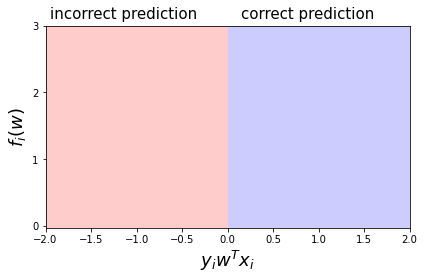

In [54]:
plot_loss_diagram()

### 0/1 loss

- Binary state of happiness.
- We are happy (loss=0) when the $y_iw^Tx_i \geq 0$ 
$$y_iw^Tx_i \geq 0, f_i(w) = 0$$
- We are unhappy (loss=1) when $y_iw^Tx_i < 0$ 
$$y_iw^Tx_i < 0, f_i(w) = 1$$

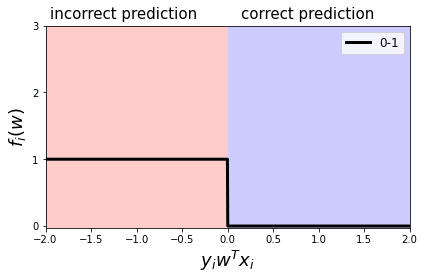

In [5]:
grid = np.linspace(-2, 2, 1000)
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=3, label="0-1")
plt.legend(loc="best", fontsize=12);

### Preferences

- In 0/1 loss we are giving the same penalty to the examples where we are only slightly incorrect vs very incorrect. 
- It might be nice to have some preferences: <br>
    - <span style="color:green">**correct and confident**</span> (positive value with big magnitude of $y_iw^Tx_i$) <br> **>** <span style="color:cyan"> **correct and hesitant** </span>  (positive value with small magnitude of $y_iw^Tx_i$) <br> **>** <span style="color:orange">**incorrect and hesitant**</span> (negative value with small magnitude of $y_iw^Tx_i$) <br> **>**  <span style="color:red">**incorrect and confident**</span> (negative value with big magnitude of $y_iw^Tx_i$) 

### Exponential loss

- Punish the wrong predictions exponentially. 
$$\exp(-y_iw^Tx_i)$$ 

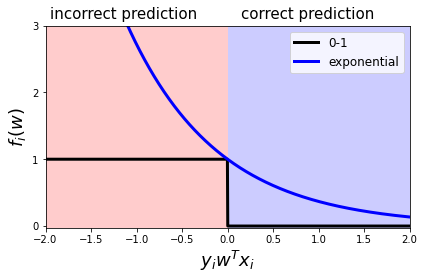

In [6]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=3, label="0-1")
plt.plot(grid, np.exp(-grid), color="blue", linewidth=3, label="exponential")
plt.legend(loc="best", fontsize=12);

### Intuition 

- The function gets smaller as $y_iw^Tx_i$ gets larger, so it encourages correct classification. 
- So if we minimize this loss, which means if we move down and to the right, it is encouraging positive values and hence correct predictions. 

### Hinge Loss 

- Confident and correct examples are not penalized 
- Grows linearly for negative values in a linear fashion. 

$$max(0, 1 - y_iw^Tx_i)$$ 

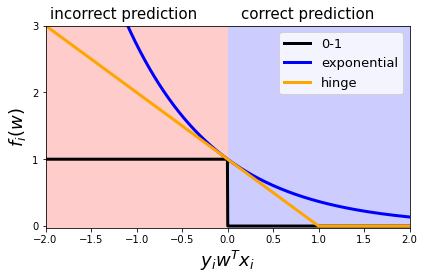

In [7]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=3, label="0-1")
plt.plot(grid, np.exp(-grid), color="blue", linewidth=3, label="exponential")
plt.plot(grid, np.maximum(0, 1 - grid), color="orange", linewidth=3, label="hinge")
plt.legend(loc="best", fontsize=13);

- When you use Hinge loss with L2 regularization, it's called a linear support vector machine.  
    $$f(w) = \sum_{i=1}^n max\{0,1-y_iw^Tx_i\} + \frac{\lambda}{2} \lVert w\rVert_2^2$$
- For more mathematical details on these topics see the following slide decks. 
    - [Linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L20.pdf)
    - [More on linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L19.pdf)

### Logistic loss (logloss)

- Used in logistic regression
- Grows linearly for negative values which makes it less sensitive to outliers. 

  $$\log\left(1+\exp(-y_iw^Tx_i)\right)$$

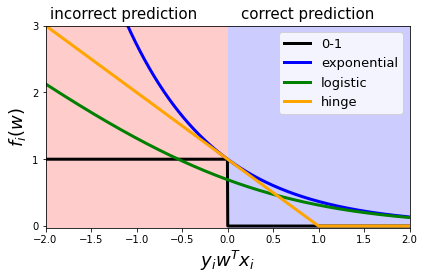

In [8]:
plot_loss_diagram()
plt.plot(grid, grid < 0, color="black", linewidth=3, label="0-1")
plt.plot(grid, np.exp(-grid), color="blue", linewidth=3, label="exponential")
plt.plot(grid, np.log(1 + np.exp(-grid)), color="green", linewidth=3, label="logistic")
plt.plot(grid, np.maximum(0, 1 - grid), color="orange", linewidth=3, label="hinge")
plt.legend(loc="best", fontsize=13);

### Sigmoid vs. logistic loss

- A common source of confusion: 
    - Sigmoid: $\frac{1}{(1+\exp(-z))}$
    - logistic loss: $\log(1+\exp(-z))$
- They look very similar and both are used in logistic regression.
- They have very different purposes. 

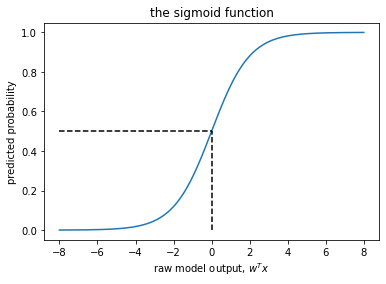

In [9]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

### Sigmoid vs. logistic loss

- Sigmoid function: $$\frac{1}{(1+\exp(-z))}$$
    - Maps $w^Tx_i$ to a number in $[0,1]$, to be interpreted as a probability. 
    - This is important in `predict_proba`. 

- Logistic loss: $\log(1+\exp(-z))$ 
    - Maps $y_iw^Tx_i$ to a positive number, which is the loss contribution from one training example. 
    - This is important in `fit`.

### Another source of confusion 

- You might see this alternative formulation for logistic loss. 
- For example see [here](https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training) or [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).


$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$

- Although this looks very different than the loss function we saw before, they produce the same loss. 
- This is also referred to as cross-entropy loss. 
- Logistic loss = cross-entropy loss 

### The key difference between them

- This formulation assumes the classes to be 0 and 1. 
$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$
   
- Our previous formulation assumes classes to be -1 and +1. 
  $$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$    

### Which loss function should I use?

- This part is more of an art than science. You should consider the following questions:
- What kind of penalty I want to put on the examples which are far away from the truth?
- Many other loss functions available out there. In fact, ML researchers come up with their own loss functions based on their needs.

<br><br><br><br>

## Regularization: Motivation and notation

### Complex models and the fundamental tradeoff

- We’ve said that complex models tend to overfit more.
- Recall: polynomial degree and train vs. validation scores. 

Let's generate some synthetic data

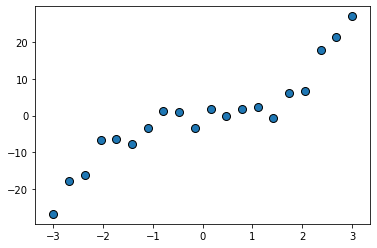

In [10]:
n = 20
np.random.seed(4)
X_train = np.linspace(-3, 3, n)
y_train = X_train ** 3 + npr.randn(n) * 3

n = 20
X_valid = np.linspace(-3, 3, n)
y_valid = X_valid ** 3 + npr.randn(n) * 3

# transforming the data to include another axis
X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

X_valid = X_valid[:, np.newaxis]
y_valid = y_valid[:, np.newaxis]

# plt.scatter(X_train, y_train, color="blue")
mglearn.discrete_scatter(X_train, y_train, s=8);

Let's fit polynomials of different degrees on the synthetic data. 

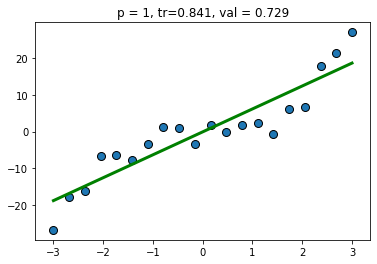

In [11]:
def f(degree=1):
    plot_poly_deg(X_train, y_train, X_valid, y_valid, degree=degree, valid=True)


interactive(
    f,
    degree=widgets.IntSlider(min=1, max=20, step=1, value=1),
)

- The training score goes up as we increase the degree of the polynomial, and is highest for $p = 19$.
- The validation score first goes up and then down. 

- The validation score is highest for $p = 3$, and it goes down as we increase the degree after that; we start overfitting after $p=3$.   

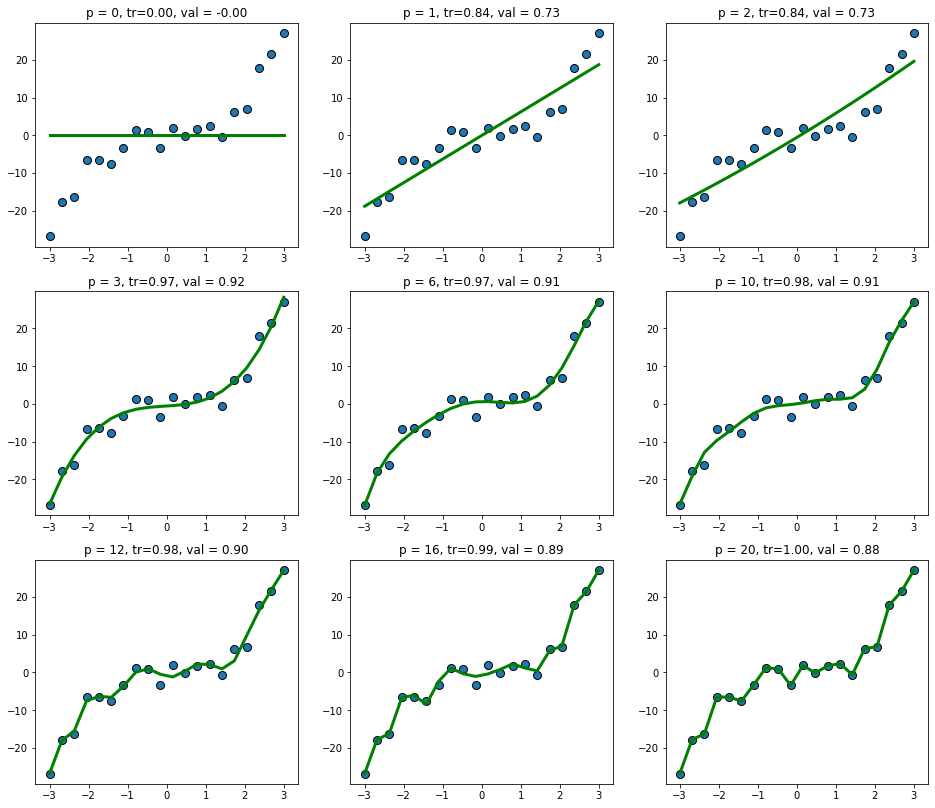

In [12]:
plot_train_valid_poly_deg(X_train, y_train, X_valid, y_valid)

- So there is a tradeoff between complexity of models and the validation score. 
- But what if we need complex models? 
- In supervised ML we try to find the mapping between $X$ and $y$, and usually the "true" mapping from $X$ to $y$ is complex.
    - Might need high-degree polynomial.
    - Might need to use many features, and don't know "relevant" ones.    

### Controlling model complexity

A few methods to control complexity: 
- Reduce the number of features (feature selection)
- Model averaging: average over multiple models to decrease variance (e.g., random forests). 
        
<center>
<img src="img/random-forest-train-valid.png" width="600" height="800">
</center>    

- **Regularization: add a penalty on the complexity of the model**


### Terminology and notation

#### Reminder: L0, L1, and L2 norms

Given a vector $w$, 

- L0 norm $\lVert w \rVert \rightarrow$ the number of non-zero elements in $w$  
- L1 norm $\lVert w \rVert_1 = \lvert w_1 \rvert + \lvert w_2 \rvert + \dots + \lvert w_n \rvert$ 
- L2 norm $\lVert w \rVert_2 = (w_1^2 + w_2^2 + \dots + w_n^2)^{1/2}$ 
- Square of the L2 norm $\lVert w \rVert_2^2 = (w_1^2 + w_2^2 + \dots + w_n^2)$ 

In [13]:
from numpy import array
from numpy.linalg import norm

w = array([0, -2, 4])

l0 = norm(w, 0)  # number of non-zero values
l1 = norm(w, 1)  # sum of absolute values
l2 = norm(w, 2)  # square root of sum of the squared values
print("The l0 norm of %s is: %0.3f" % (w, l0))
print("The l1 norm of %s is: %0.3f" % (w, l1))
print("The l2 norm of %s is: %0.3f" % (w, l2))

The l0 norm of [ 0 -2  4] is: 2.000
The l1 norm of [ 0 -2  4] is: 6.000
The l2 norm of [ 0 -2  4] is: 4.472


In [14]:
# norms of a vector
from numpy import array
from numpy.linalg import norm

w = array([0, -2, 3, 0])
# l0 norm is the number of non-zero values in a vector
print("The l0 norm of %s is: %0.3f" % (w, norm(w, 0)))

# l1 norm is the sum of the absolute values in a vector.
print("The l1 norm of %s is: %0.3f" % (w, norm(w, 1)))

# l2 norm is square root of the sum of the squared values in a vector.
print("The l2 norm of %s is: %0.3f" % (w, norm(w, 2)))

The l0 norm of [ 0 -2  3  0] is: 2.000
The l1 norm of [ 0 -2  3  0] is: 5.000
The l2 norm of [ 0 -2  3  0] is: 3.606


- We can write least squares using this notation.
- It's the square of the L2 norm of the difference between predicted y's and true y's.  

$$ f(w) = \frac{1}{2}\sum_{i=1}^{n}{(w^Tx_i - y_i)^2}$$

$$ f(w) = \frac{1}{2}\lVert{Xw -y}\rVert_2^2$$

### Vectorization

- We can organize all the training examples into a matrix $Z$ with one row per training example. 
- Then compute the predictions for the whole dataset succinctly as $Zw$ for the whole dataset: 
- We take each row of $Z$ and dot-product it with $w$. So the result is a vector of all our predictions.

$$Zw = \begin{bmatrix}w^Tz_0 \\ w^Tz_1 \\ \vdots \\ w^Tz_n\end{bmatrix} = \begin{bmatrix}z_0w \\ z_1w \\ \vdots \\ z_nw\end{bmatrix} = \begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix} $$



- Sometimes, we refer to the transformed data (e.g., after applying polynomial transformations) as $Z$ (instead of $X$) and the weights associated with the transformed features as $v$ (instead of $w$). 
- So the least square loss function after applying polynomial transformations can be written as:  

$$f(w) = \frac{1}{2}\lVert{Zv -y}\rVert_2^2$$

<br><br><br><br>

## Complexity penalties and L0 regularization 

### Model selection: complexity penalty 

- We want to fit the data and have a simple model. 
- So far we have been doing model selection using cross validation. 
- Another way to select a model is by penalizing complex models.  

4.814326590118406

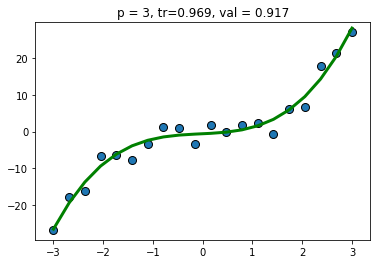

In [31]:
from sklearn.metrics import mean_squared_error

pt = PolynomialFeatures(degree=3)
X_train_3 = pt.fit_transform(X_train) 
lr_degree3 = LinearRegression().fit(X_train_3, y_train)
plot_poly_deg(X_train, y_train, X_valid, y_valid, degree=3, valid=True)
mean_squared_error(y_train, lr_degree3.predict(X_train_3))

4.7741942412511085

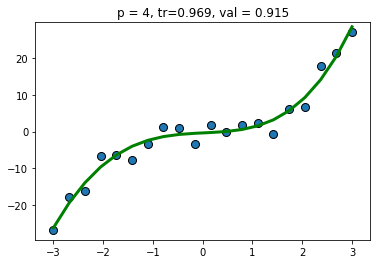

In [30]:
pt = PolynomialFeatures(degree=4)
X_train_4 = pt.fit_transform(X_train) 
lr_degree4 = LinearRegression().fit(X_train_4, y_train)
plot_poly_deg(X_train, y_train, X_valid, y_valid, degree=4, valid=True)
mean_squared_error(y_train, lr_degree4.predict(X_train_4))

### Complexity penalty

- Here we measure complexity in terms of the number of degrees of freedom or parameters in the model
- In case of polynomial features, minimize the training error + the degree of 
polynomial. 
- Therefore, we state the problem as: find $p$ that minimizes 

$$ score(p) = \frac{1}{2}\lVert{Z_pv -y}\rVert^2 + p$$

- where
    - $p \rightarrow$ degree of polynomial in polynomial transformations
    - $Z_p \rightarrow$ transformed polynomial features
    - $v \rightarrow$ weights associated with $Z_p$

- If we use $p=3$, use loss + 3 as the total loss. 
- If we use $p=4$, use loss + 4 as the total loss. 
- If two $p$ have similar losses, this prefers smaller $p$.

### Optimizing this score

$$ score(p) = \frac{1}{2}\lVert{Z_pv -y}\rVert^2 + p$$

- Form $Z_0$, solve for $v$ compute $ score(0) = \frac{1}{2}\lVert{Z_0v -y}\rVert^2 + 0$
- Form $Z_1$, solve for $v$ compute $ score(1) = \frac{1}{2}\lVert{Z_1v -y}\rVert^2 + 1$
- Form $Z_2$, solve for $v$ compute $ score(2) = \frac{1}{2}\lVert{Z_2v -y}\rVert^2 + 2$
- Form $Z_3$, solve for $v$ compute $ score(3) = \frac{1}{2}\lVert{Z_3v -y}\rVert^2 + 3$

Choose the degree with the lowest score. 
- We need to decrease the training error by at least 1 to increase degree by 1. 

### Model selection

There are many scores usually with the form: 
$$ score(p) = \frac{1}{2}\lVert{Z_pv -y}\rVert^2 + \lambda k$$

$k \rightarrow \text{estimated parameters/degrees of freedom}$

$\lambda \rightarrow \text{penalization factor}$

- Pick the model with lowest score.
- The way we choose $\lambda$ gives us different statistical measures for model selection. 
- For example
    - AIC sets $\lambda = 1$ and penalizes the model complexity by the degree of freedom
    - BIC sets $\lambda = log(N)$, where $N$ is the number of examples. 
    - MSE does not penalize the model
    - Classification error does not penalize the model 

More on these measures [here](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf). 

###  Remember the search and score methods for feature selection 

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  

### Scoring using complexity penalties

- Find $S$ and $W_s$ minimizing the squared error + the number of selected features 

$$ score(S) = \frac{1}{2}\lVert{X_{S}w_S -y}\rVert_2^2 + size(S) $$


- $X_{S}$ is features $S$ of examples $X$. 
- Example
    - Suppose $S_1 = \{f_1, f_2, f_4\}$ $S_2 = \{f_1, f_2, f_4, f_5\}$ have similar error, it prefers $S_1$.
    - It prefers removing $f_5$ instead of keeping it with a small weight.
- Instead of $size(S)$, we usually write "$L0$ norm".

### $L0$ "norm"  and the number of features used

- In linear models, setting $w_j = 0$ is the same as removing the feature.
- Example: $$\hat{y_i} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4$$
- $L0$ "norm" is the number of non-zero values.  
- If $w = \begin{bmatrix}0.8 \\ 0.0 \\ 0.03 \\0.1\end{bmatrix}$, $\lVert w\rVert_0 = 3$ and if $w = \begin{bmatrix}0.0 \\ 0.0 \\ 0.22 \\0.0\end{bmatrix}$, $\lVert w\rVert_0 = 1$


### Example 

Imagine the following two weight vectors which give the same error. 

$$w^1 = \begin{bmatrix}100 \\0\end{bmatrix}  w^2 = \begin{bmatrix}99.98 \\0.03\end{bmatrix}$$  

- Which one would be chosen by L0 regularization? 
    - $\lVert w^1\rVert_0 = 1$ and $\lVert w^2\rVert_0 = 2$. So it will pick $w^1$

### Scoring using $L0$ "norm" 

- Most common "scores" have the form.

$$f(w) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2 + \lambda \lVert w\rVert_0$$

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$
- $\lambda \rightarrow$ penalty parameter
- $\lVert w\rVert_0 \rightarrow$  L0 norm of $w$      
    - The number of non-zero values in $w$.                

- To increase the degrees of freedom by one, need to decrease the error by $\lambda$. 
- Prefer smaller degrees of freedom if errors are similar. 
- Can't optimize because the function is discontinuous in $\lVert w\rVert_0$
    - Search over possible models 

### Notes
1. In the equation below smaller $\lVert w\rVert_0$ means we discard most of the features. 
$$ f(w) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$
2. In the above equation, larger $\lambda$ means aggressive feature pruning. 

<br><br><br><br>

## L2 regularization 

### Idea of regularization: Pick the line/hyperplane with smaller slope 

- Keep all the features but reduce the magnitude of coefficients/weights.
- Assuming red and green models have the same training score and if you are forced to choose one of them, which one would you pick?
    - **Pick green because its slope is smaller.**

<center>
<img src='img/green_or_red.png' width="600" height="600" />
</center>    



### Why pick the line/hyperplane with smaller slope? 
<br>
<center>
<img src='img/green_or_red.png' width="500" height="500" />
</center>    

- This can be proved mathematically. 
- Small change in $x_i$ has a smaller change in prediction $y_i$
- Green line's predictions are less sensitive to the training data. 
- Since green $w$ is less sensitive to training data, validation error might be lower. 

L2 regularization helps us with making $w$ less sensitive to the data.

- Standard regularization strategy is L2 regularization
    - We incorporate L2 penalty in the loss function $f(w)$: 
$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d w_j^2 \text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- $\lVert Xw - y\rVert_2^2 \rightarrow$ square of the $L2$ norm of $Xw -y$
- $\lambda \rightarrow$ regularization strength    
- $\lVert w\rVert_2^2 \rightarrow$  square of the L2 norm of $w$      
    - sum of the squared weight values.              

### L2 regularization 

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Objective balances getting low error vs. having small slopes $w_j$
- In terms of fundamental trade-off:
    - You can increase the training error. 
    - Nearly-always reduces overfitting and the validation error.    

### L2 regularization demo

- Imagine your training set only contains the $y$-values, and they are shown above.
- How can you predict a new $y$?
- Reasonable idea: predict the mean value.

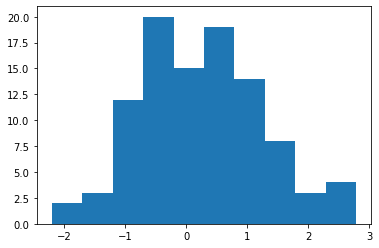

In [41]:
N = 100
y = npr.randn(N, 1)
plt.hist(y);

In [42]:
class MeanPredictor:
    def fit(self, y):
        self.mean = np.mean(y)

    def predict(self):
        return self.mean


mp = MeanPredictor()
mp.fit(y)
mp.predict()

0.2567679229578858

Now imagine we have one feature $x$.

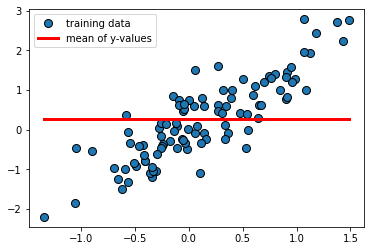

In [43]:
x = y / 2 + npr.randn(N, 1) / 3
mglearn.discrete_scatter(x, y, s=8, labels=["training data"])
mean = np.mean(y)
plt.plot((min(x), max(x)), (mean, mean), linewidth=3, c="red", label="mean of y-values")
plt.legend();

Ok, but, why not use this feature? Let's do linear regression.

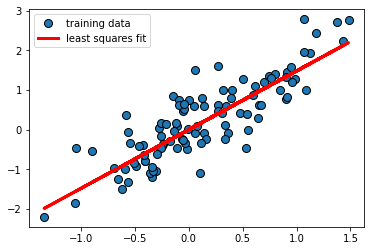

In [44]:
mglearn.discrete_scatter(x, y, s=8, labels=["training data"])
w = np.sum(x * y) / np.sum(x * x)
plt.plot(x, w * x, linewidth=3, c="red", label="least squares fit")
plt.legend();

- But what if we don't trust this feature that much?
- Let's take a compromise between our prior model (mean value) and our new model.
- We can achieve this by penalizing large values of $w$.
- The loss becomes

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + {\lambda} \lVert w\rVert_2^2$$

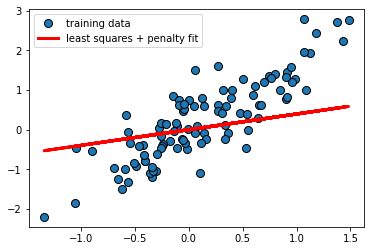

In [45]:
mglearn.discrete_scatter(x, y, s=8, labels=["training data"])
w = np.sum(x * y) / (np.sum(x * x) + 100)
plt.plot(x, w * x, linewidth=3, c="red", label="least squares + penalty fit")
plt.legend();

### Regularization demo

- Let's generate some synthetic data with N = 20 points. 

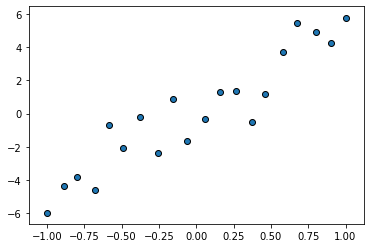

In [46]:
np.random.seed(4)
N = 20
X = np.linspace(-1, 1, N) + npr.randn(N) * 0.01
X = X[:, None]
y = npr.randn(N, 1) + X * 5

mglearn.discrete_scatter(X, y, s=6, labels=["training data"]);

Let's fit with degree $N-1$ polynomial

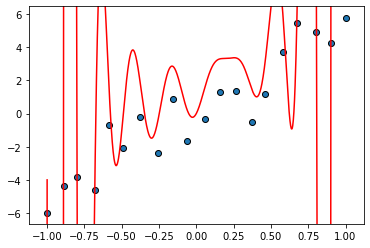

In [47]:
pf = PolynomialFeatures(19)
Z = pf.fit_transform(X)

lr = LinearRegression()
lr.fit(Z,y)
w = lr.coef_.flatten()
grid = np.linspace(min(X), max(X), 1000)
grid_poly = pf.fit_transform(grid)

mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
plt.plot(grid, grid_poly @ w, c="red");

- Problem: this results are crazy (overfitting). 
- Bigger values of weights means the model is very sensitive to the training data. 

In [48]:
pd.DataFrame(w, index=pf.get_feature_names_out(), columns=["weights"]).tail()

,weights
x0^15,-5.150150e+07
x0^16,-5.316861e+06
x0^17,3.466582e+07
x0^18,1.482311e+06
x0^19,-9.517721e+06


In [22]:
print(max(abs(w)))

51501499.25985041


### Solution 1: Use a lower degree polynomial

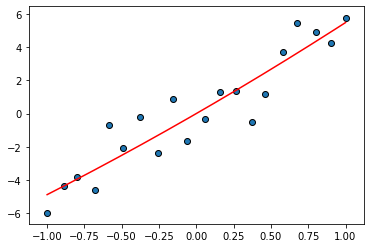

In [51]:
pf = PolynomialFeatures(2)
Z = pf.fit_transform(X)
lr = LinearRegression()
lr.fit(Z,y)
w = lr.coef_.flatten()
grid_poly = pf.fit_transform(grid)
mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
plt.plot(grid, grid_poly @ w, c="red");

- The lower degree polynomial looks good.
- But if the true relationship really was complicated? Then if we restricted the degree of the polynomial, we'd miss out on it.


### Solution 2: Use regularization 

- The idea of regularization is to "regularize" weights so that they are small and so less sensitive to the data. 

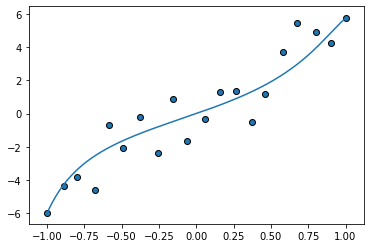

In [52]:
pf = PolynomialFeatures(19)
Z = pf.fit_transform(X)

r = Ridge() # Regularized linear regression 
r.fit(Z, y)
w = r.coef_.flatten()
mglearn.discrete_scatter(X, y, s=6, labels=["training data"])
grid_poly = pf.fit_transform(grid)
plt.plot(grid, grid_poly @ w);

In [53]:
pd.DataFrame(w, index=pf.get_feature_names_out(), columns=["weights"])

,weights
1,0.000000
x0,3.136081
x0^2,0.489320
x0^3,1.620915
x0^4,0.085908
x0^5,0.774190
x0^6,-0.088113
x0^7,0.336446
x0^8,-0.138795
x0^9,0.122758


In [26]:
print(max(abs(w)))

3.1360810773236714


- Regularization helped! Even though we used a degree $N-1$ polynomial, we didn't end up with a crazy model.
- We are keeping all the complex features but assigning small weights to higher degree polynomial. 
- We can add regularization to many models, not just least squares with a polynomial basis.

### Again, why are small weights better? 
- Suppose $x_1$ and $x_2$ are nearby each other. 
- We might expect that they have similar $\hat{y}$. 
- If we change feature1 value by a small amount $\epsilon$ in $x_2$, leaving everything else the same, we might think that the prediction would be the same.
- But if we have bigger weights small change in $x_2$ has a large effect on the prediction. 

In [27]:
x_1 = np.array([1, 1, 0, 1, 1, 0])
x_2 = np.array([0.8, 1, 0, 1, 1, 0])
weights = np.array([100, 0.1, 1, 0.22, 4, 3])

print("x_1 prediction: ", x_1.dot(weights))
print("x_2 prediction: ", x_2.dot(weights))

x_1 prediction:  104.32
x_2 prediction:  84.32


### Why are small weights better? 
- In linear models, the rate of change of the prediction function is proportional to the individual weights. 
- So if we want the function to change slowly, we want to ensure that the weights stay small.
- The idea is to avoid putting all our energy into one features, which might give us over-confident predictions and lead to overfitting. 

### Have we seen this before? 

- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html): Linear Regression with L2 regularization 

> class sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

> Linear least squares with l2 regularization. Minimizes the objective function: $$||y - Xw||^2_2 + alpha * ||w||^2_2$$
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization.

- Uses the hyperparameter $\alpha$ for regularization strength instead of $\lambda$; larger value of $\alpha$ means more regularization.
$$f(w) = \lVert Xw - y\rVert_2^2 + \alpha \lVert w\rVert_2^2$$
 

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Linear Regression with L2 regularization 

> class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

- `C`: default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. 

### How does `alpha` affect the weights?  

In [35]:
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

housing = fetch_california_housing(as_frame=True)
X = housing["data"]
X = MinMaxScaler().fit_transform(housing.data)
pf = PolynomialFeatures(degree=2, include_bias=False)
X = pf.fit_transform(X)
y = housing["target"]

In [36]:
X.shape

(20640, 44)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LinearRegression().fit(X_train, y_train)

In [38]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.69
Test set score: -0.73


In [39]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train) # default: alpha = 1
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.63
Test set score: 0.61


In [40]:
ridge01 = Ridge(alpha=0.01).fit(X_train, y_train) # smaller alpha = 1
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.66
Test set score: 0.50


In [41]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train) # bigger alpha = 10
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

Training set score: 0.61
Test set score: 0.59


In [42]:
ridge100 = Ridge(alpha=100).fit(X_train, y_train) # even bigger alpha = 100
print("Training set score: {:.2f}".format(ridge100.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge100.score(X_test, y_test)))

Training set score: 0.57
Test set score: 0.55


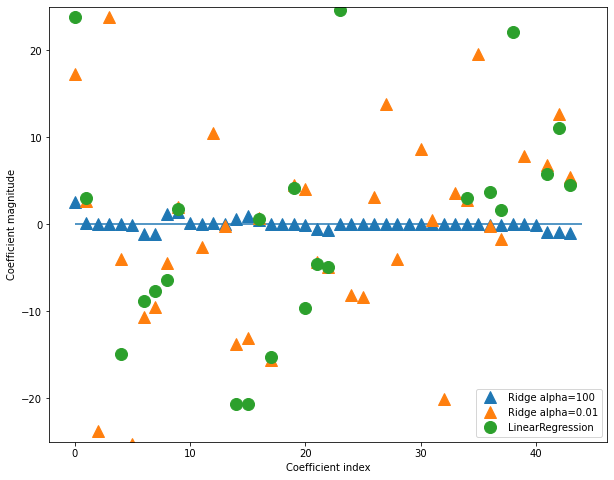

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(ridge100.coef_, "^", markersize=12, label="Ridge alpha=100")
plt.plot(ridge01.coef_, "^", markersize=12, label="Ridge alpha=0.01")
plt.plot(lr.coef_, "o", markersize=12, label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend();

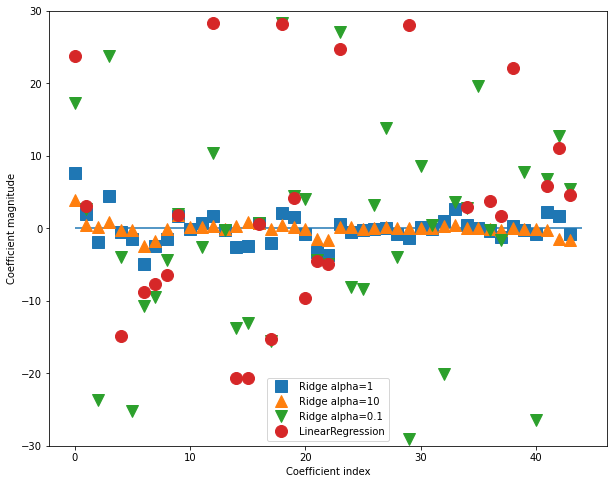

In [53]:
plt.figure(figsize=(10, 8))
plt.plot(ridge.coef_, "s", markersize=12, label="Ridge alpha=1")
plt.plot(ridge10.coef_, "^", markersize=12, label="Ridge alpha=10")
plt.plot(ridge01.coef_, "v", markersize=12, label="Ridge alpha=0.1")
plt.plot(lr.coef_, "o", markersize=12, label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-30, 30)
plt.legend();

- We also observe the fundamental tradeoff. 
- As we increase `alpha` the weights become smaller and smaller. 
- We see that the rounded values of some weights are close to zero. 

## Summary

- Loss functions
    - 0/1 loss
    - Exponential loss
    - Hinge loss
    - Logistic loss
- Adding complexity penalties in the loss function
    - L0 penalty 
    - L2 regularization 
- Coming up
    - More on L2 regularization
    - L1 regularization 

<br><br><br><br>

### Notes on L2-regularization

1. Introducing L2 regularization to the model means making it less sensitive to changes in $X$.
2. Introducing L2 regularization to the model can results in worse performance on the training set. 
3. Imagine that you fit `Ridge` twice with different values of $\alpha$, $\alpha = 0$ and $\alpha=10$. You are given the weights learned from two different models below. Without knowing which weights came from which model, you can guess that $w^1$ probably corresponds to $\alpha = 0$ and $w^2$ probably corresponds to $\alpha = 10$.(the weights of $w^2$ is more punished)
$$w^1 = \begin{bmatrix} 32.43\\23.14\\16.4\end{bmatrix} \text{ and }w^2 = \begin{bmatrix} 2.03\\1.2\\0.4\end{bmatrix}$$ 